In [1]:
1+1

2

In [3]:
import os

%pwd

'/Users/priyaroy/Documents/Projects/nlp-projects/CommentClassifier/research'

In [4]:
os.chdir("../")
%pwd

'/Users/priyaroy/Documents/Projects/nlp-projects/CommentClassifier'

In [25]:
from dataclasses import dataclass
from pathlib import Path

@dataclass
class DataTransformationConfig:
    root_dir: Path
    data_path: Path
    tokenizer_name: Path
    text_column: str
    label_column: bool
    stopwords: str
    lowercase: bool
    remove_special_characters: bool
    remove_extra_spaces: bool
    
    
    

In [6]:
from src.CommentClassifier.constants import *
from src.CommentClassifier.utils.common import read_yaml, create_directories

In [12]:
class ConfigurationManager:
    def __init__(self,
                 config_path=CONFIG_FILE_PATH,
                 params_filepath=PARAMS_FILE_PATH):
        self.config=read_yaml(config_path)
        self.paramss=read_yaml(params_filepath)

        create_directories([self.config.artifacts_root])

    def get_data_transformation_config(self)-> DataTransformationConfig:
        config=self.config.data_transformation

        create_directories([config.root_dir])

        data_transformation_config=DataTransformationConfig(
            root_dir=config.root_dir,
            data_path=config.data_path,
            tokenizer_name=config.tokenizer_name,
            text_column=config.text_column,
            label_column=config.label_column,
            stopwords=config.stopwords,
            lowercase=config.lowercase,
            remove_special_characters=config.remove_special_characters,
            remove_extra_spaces=config.remove_extra_spaces
        )

        return data_transformation_config

In [64]:
import os
from src.CommentClassifier.logging import logger
from datasets import load_from_disk
import os
import pandas as pd
import seaborn as sns
import yaml
import nltk
import re
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/priyaroy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Data Transformation Component

In [65]:
# Data Transformation Class
class DataTransformation:
    def __init__(self,config:DataTransformationConfig):
        self.config=config
        
    def clean_text(self, text):
        """
        Perform text cleaning: remove special characters, extra spaces, and stopwords.
        """
        STOPWORDS = set(stopwords.words(self.config.stopwords))
        text = text.lower() if self.config.lowercase else text
        text = re.sub(r"[^a-zA-Z\s]", "", text) if self.config.remove_special_characters else text
        text = " ".join(text.split()) if self.config.remove_extra_spaces else text
        text = " ".join([word for word in text.split() if word not in STOPWORDS])
        return text
    
    def transform_data(self):
        """
        Load dataset, clean text, and save transformed data.
        """
        file_path = os.path.join(self.config.data_path, "train.csv")
        df = pd.read_csv(file_path)

        df[self.config.text_column] = df[self.config.text_column].astype(str).apply(self.clean_text)
        
        # Split the dataset into train, test, and validation sets
        train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)  # 80% train, 20% for temp
        val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)  # Split remaining 20% into 10% test, 10% validation

        # Save the transformed data into CSV files
        train_df.to_csv(os.path.join(self.config.root_dir,  "train.csv"), index=False)
        val_df.to_csv(os.path.join(self.config.root_dir, "val.csv"), index=False)
        test_df.to_csv(os.path.join(self.config.root_dir, "test.csv"), index=False)

        print("Transformed data saved successfully as train.csv, test.csv, and val.csv!")
 

In [66]:
# Run Data Transformation
config=ConfigurationManager()
data_transformation_config=config.get_data_transformation_config()
transformer = DataTransformation(config=data_transformation_config)
transformer.transform_data()

DEBUG: YAML Content Type: <class 'dict'>
DEBUG: YAML Content: {'artifacts_root': 'artifacts', 'data_ingestion': {'root_dir': 'artifacts/data_ingestion', 'source_URL': 'https://github.com/priya-roy/unhealthy-comments-Dataset/raw/refs/heads/main/commentClassification.zip', 'local_data_file': 'artifacts/data_ingestion/data.zip', 'unzip_dir': 'artifacts/data_ingestion'}, 'data_transformation': {'text_column': 'comment', 'label_column': 'healthy', 'stopwords': 'english', 'lowercase': True, 'remove_special_characters': True, 'remove_extra_spaces': True, 'root_dir': 'artifacts/data_transformation', 'data_path': 'artifacts/data_ingestion/commentClassification', 'tokenizer_name': 'nltk'}, 'tfidf_vectorizer': {'max_features': 10000, 'ngram_range': [1, 2], 'stop_words': 'english', 'min_df': 2, 'max_df': 0.9}, 'model_trainer': {'model_type': 'logistic_regression', 'solver': 'liblinear', 'penalty': 'l2', 'random_state': 42, 'max_iter': 200, 'class_weight': 'balanced'}, 'model_evaluation': {'metrics

In [57]:
class EDA:     
    def __init__(self,config:DataTransformationConfig):
        self.config=config
        self.text_column = self.config.text_column
        self.label_column = self.config.label_column
        self.data_path = self.config.data_path
    
    def load_dataset(self):
        """
        Load dataset from the transformed file.
        """
        file_path = os.path.join(self.config.root_dir, "transformed_data.csv")
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            print(f"Dataset Loaded: {df.shape} rows, {df.columns.tolist()} columns")
            return df
        else:
            raise FileNotFoundError(f"Dataset not found at {file_path}")

    def show_data_info(self, df):
        """
        Display basic dataset information.
        """
        print("\nDataset Information:\n")
        print(df.info())
        print("\nMissing Values:\n", df.isnull().sum())
        print("\nLabel Distribution:\n", df[self.config.label_column].value_counts())

    def plot_label_distribution(self, df):
        """
        Visualise the distribution of labels (toxic vs. healthy).
        """
        plt.figure(figsize=(6,4))
        sns.countplot(x=self.config.label_column, data=df, palette="coolwarm")
        plt.title("Label Distribution")
        plt.xlabel("Healthy (1) / Toxic (0)")
        plt.ylabel("Count")
        plt.show()

    def plot_text_length_distribution(self, df):
        """
        Plot distribution of comment lengths.
        """
        df["text_length"] = df[self.config.text_column].apply(lambda x: len(str(x).split()))
        plt.figure(figsize=(8,5))
        sns.histplot(df["text_length"], bins=50, kde=True, color="blue")
        plt.title("Distribution of Comment Lengths")
        plt.xlabel("Word Count")
        plt.ylabel("Frequency")
        plt.show()

    def word_cloud(self, df, label=1):
        """
        Generate a word cloud for toxic (0) or healthy (1) comments.
        """
        text_data = " ".join(df[df[self.config.label_column] == label][self.config.text_column].astype(str))
        wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text_data)

        plt.figure(figsize=(10,5))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"Word Cloud for {'Healthy' if label == 1 else 'Toxic'} Comments")
        plt.show()

    def run_eda(self):
        """
        Perform the complete EDA process.
        """
        df = self.load_dataset()
        self.show_data_info(df)
        self.plot_label_distribution(df)
        self.plot_text_length_distribution(df)
        self.word_cloud(df, label=1)  # Word cloud for healthy comments
        self.word_cloud(df, label=0)  # Word cloud for toxic comments





DEBUG: YAML Content Type: <class 'dict'>
DEBUG: YAML Content: {'artifacts_root': 'artifacts', 'data_ingestion': {'root_dir': 'artifacts/data_ingestion', 'source_URL': 'https://github.com/priya-roy/unhealthy-comments-Dataset/raw/refs/heads/main/commentClassification.zip', 'local_data_file': 'artifacts/data_ingestion/data.zip', 'unzip_dir': 'artifacts/data_ingestion'}, 'data_transformation': {'text_column': 'comment', 'label_column': 'healthy', 'stopwords': 'english', 'lowercase': True, 'remove_special_characters': True, 'remove_extra_spaces': True, 'root_dir': 'artifacts/data_transformation', 'data_path': 'artifacts/data_ingestion/commentClassification', 'tokenizer_name': 'nltk'}, 'tfidf_vectorizer': {'max_features': 10000, 'ngram_range': [1, 2], 'stop_words': 'english', 'min_df': 2, 'max_df': 0.9}, 'model_trainer': {'model_type': 'logistic_regression', 'solver': 'liblinear', 'penalty': 'l2', 'random_state': 42, 'max_iter': 200, 'class_weight': 'balanced'}, 'model_evaluation': {'metrics

/var/folders/pj/lh27tt7s3sd1zql9n09bxk4w0000gn/T/ipykernel_4437/175454447.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=self.config.label_column, data=df, palette="coolwarm")


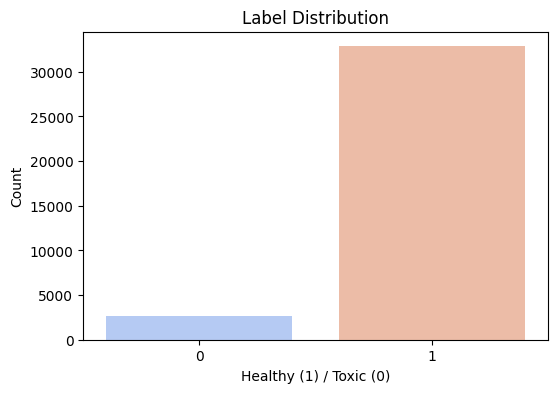

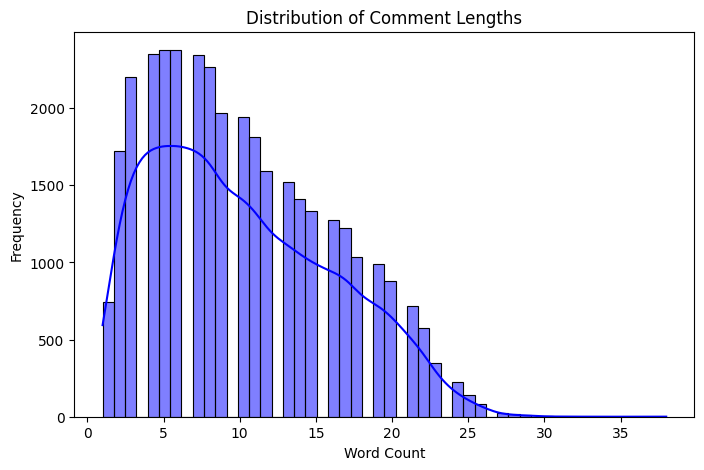

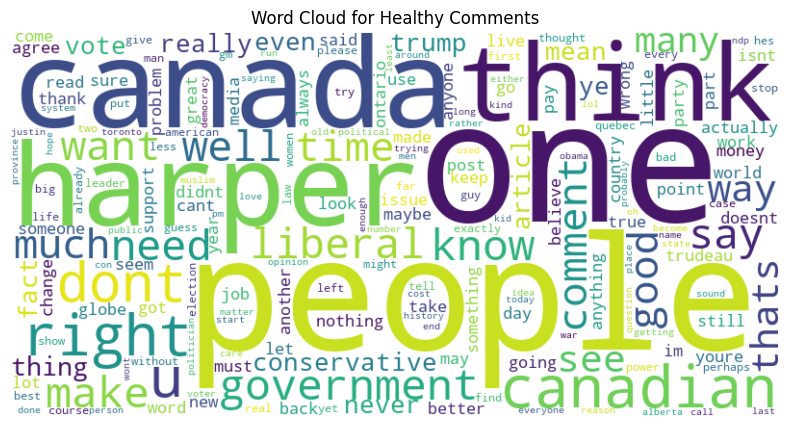

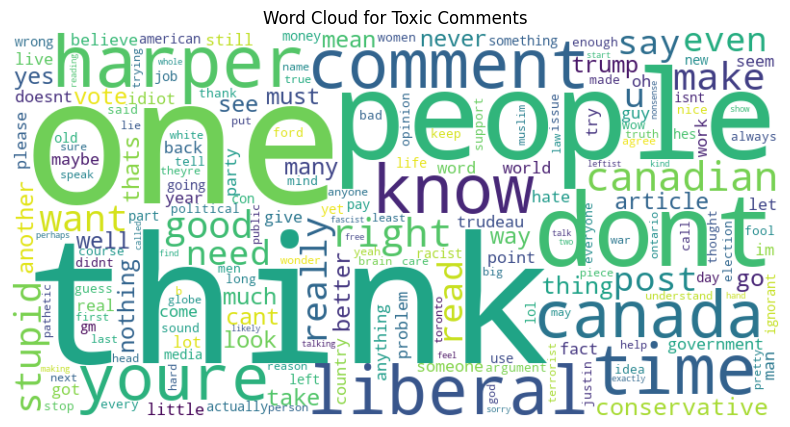

In [58]:
# Run EDA
config = ConfigurationManager()
data_transformation_config = config.get_data_transformation_config()
eda = EDA(config=data_transformation_config)  
eda.run_eda()

In [59]:

sample_comment = "This is an absolutely terrible comment!! You are wrong!"
cleaned_comment = transformer.clean_text(sample_comment)
print("Original:", sample_comment)
print("Processed:", cleaned_comment)

Original: This is an absolutely terrible comment!! You are wrong!
Processed: absolutely terrible comment wrong
